In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import numpy as np
import os as os
import netCDF4
import xarray as xr
import rasterio
from utils import load_flow_accumulation_for_dual_axis

C:\Users\pparvizi24\AppData\Local\Temp\ipykernel_39792\1400294551.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  coolwarm = cm.get_cmap('coolwarm_r')
C:\Users\pparvizi24\AppData\Local\Temp\ipykernel_39792\1400294551.py:43: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cw = cm.get_cmap("coolwarm")
C:\Users\pparvizi24\AppData\Local\Temp\ipykernel_39792\1400294551.py:99: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  run = read_runoff_csv(runoff_file).loc[time_slice].resample("H").mean()
C:\Users\pparvizi24\AppData\Local\Temp\ipykernel_39792\1400294551.py:71: DtypeWarning: Columns 

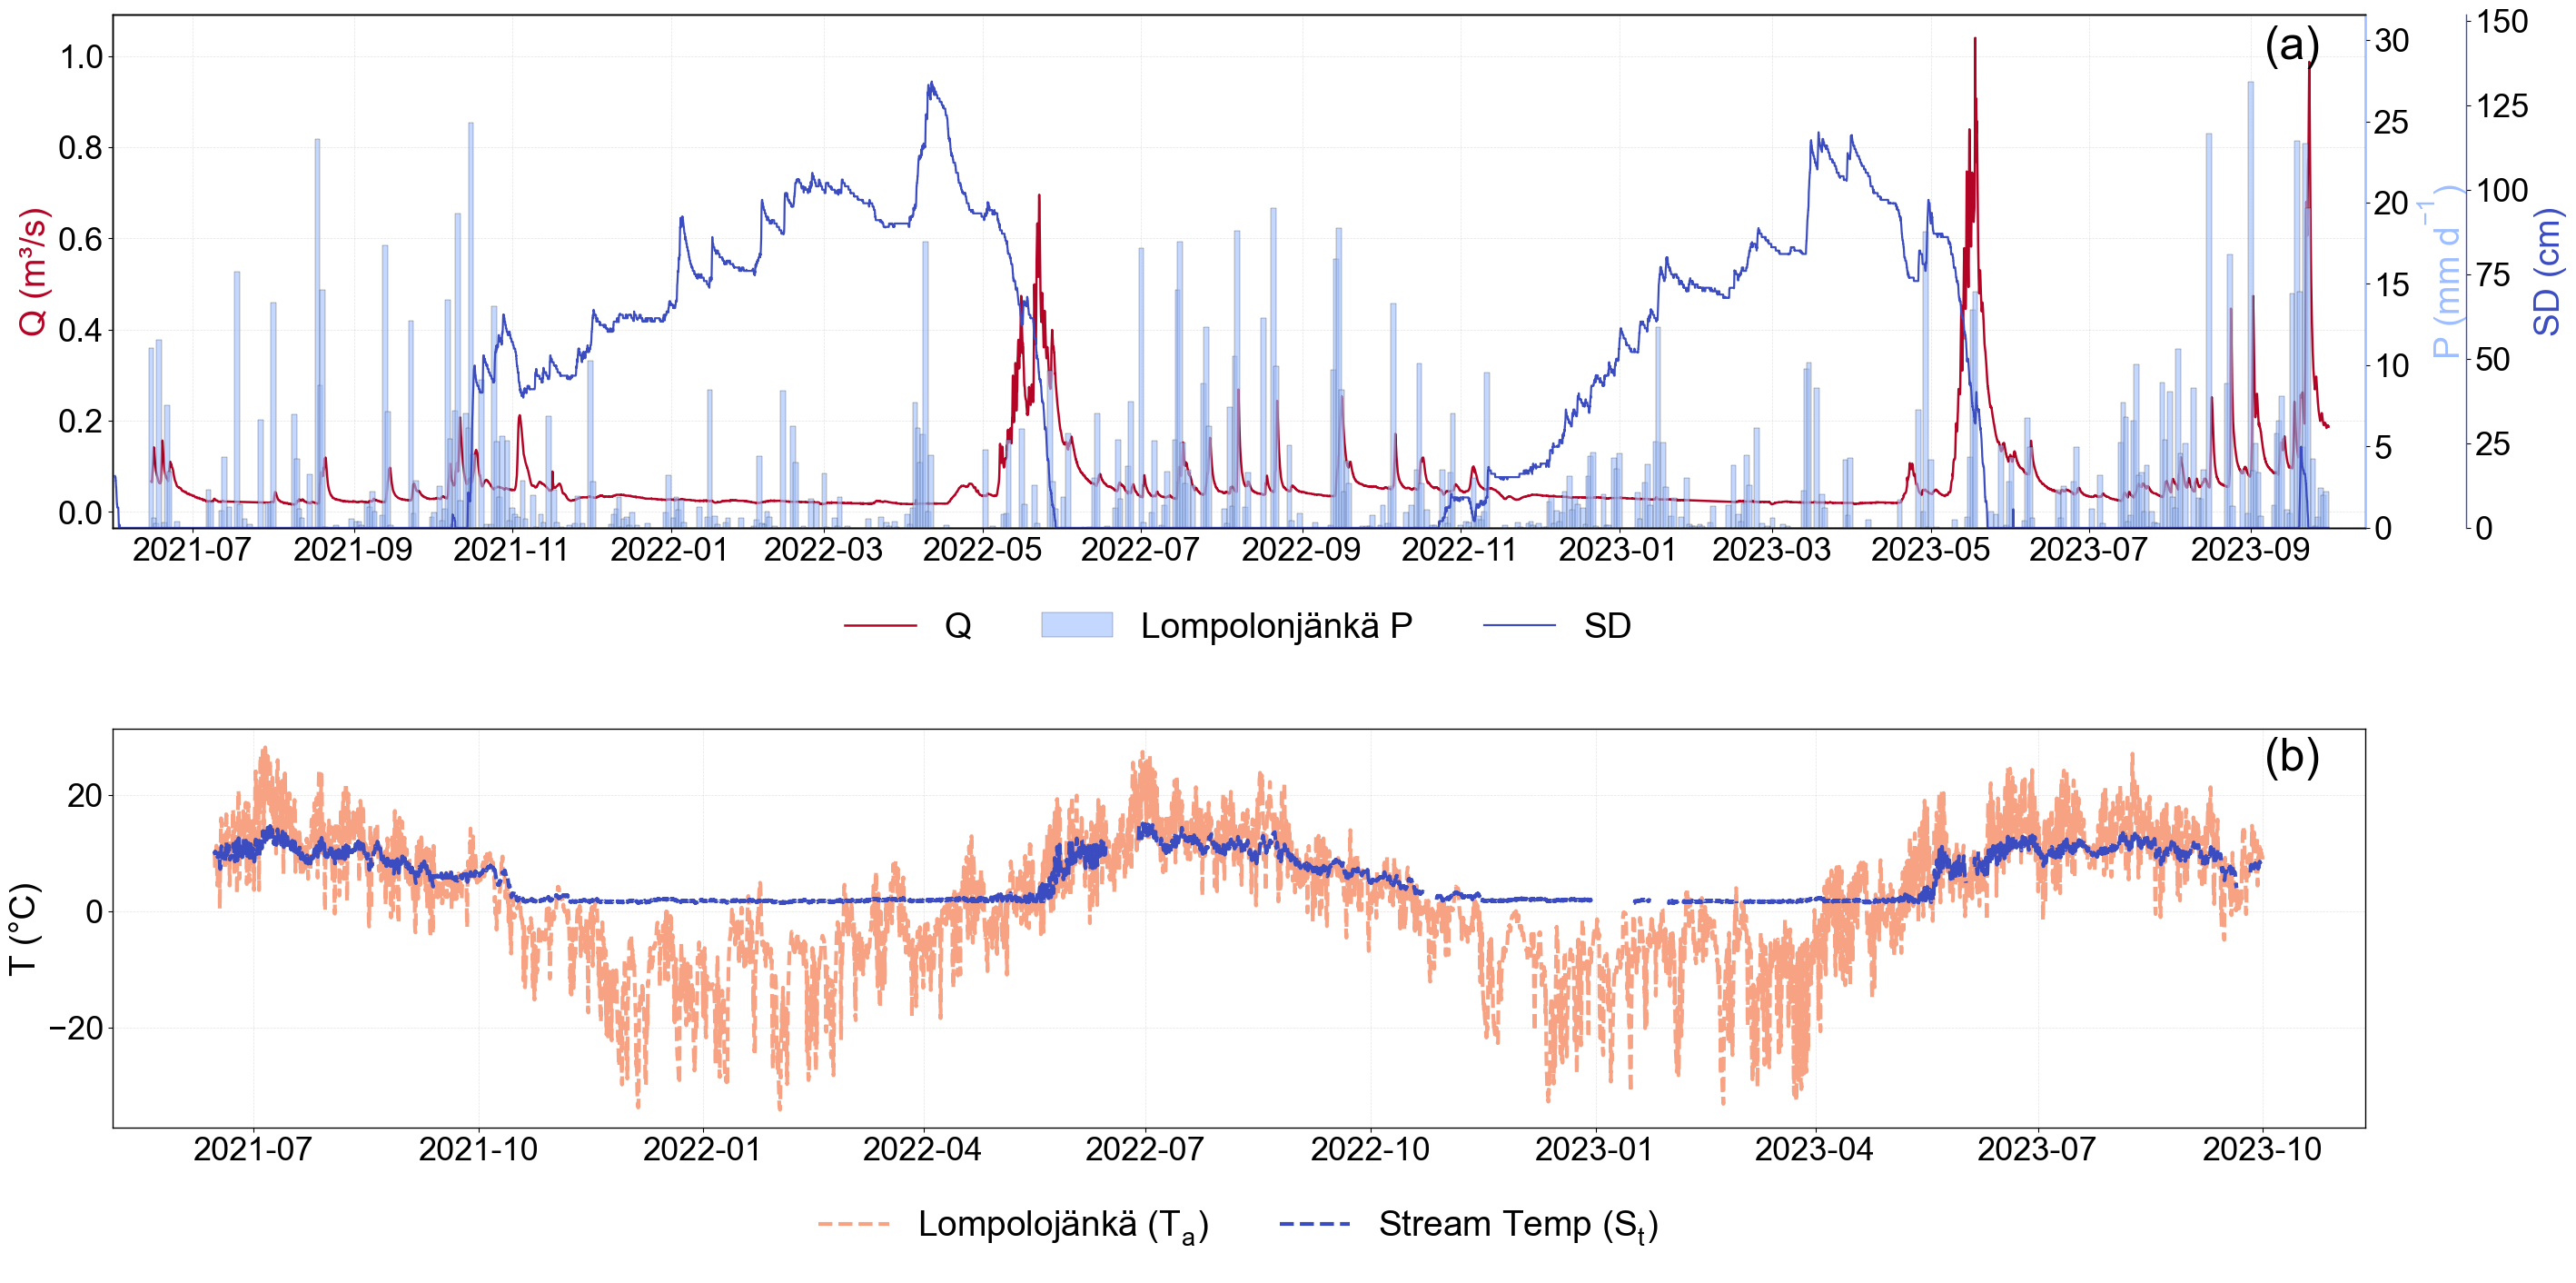

In [ ]:
def plot_Q_SWE_Lompolo_and_Tair_Twater_Lompolo_dualT(
    precip_file2,
    runoff_file,
    snow_file,
    meteo_file2,
    watertemp_file,
    time_slice,
    start_date,
    end_date,
    save_fp=None
):
    """Same as plot_Q_SWE_Lompolo_and_Tair_Twater_Lompolo but
    with dual y-axes in the lower panel: Ta on left, St on right.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    import matplotlib.cm as cm
    import xarray as xr

    # ============================================================
    # GLOBAL FONT / STYLE
    # ============================================================
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams['axes.labelsize'] = 28
    plt.rcParams['xtick.labelsize'] = 26
    plt.rcParams['ytick.labelsize'] = 26
    plt.rcParams['legend.fontsize'] = 22
    plt.rcParams['mathtext.default'] = 'regular'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.rm'] = 'Arial'

    coolwarm = cm.get_cmap('coolwarm_r')

    # Colors for (a) - use only Lompolo-related colors
    runoff_color = coolwarm(0.0)
    swe_color = coolwarm(1.0)
    precip2_color = coolwarm(0.7)

    # Colors for (b)
    cw = cm.get_cmap("coolwarm")
    water_color = cw(0.0)
    air2_color = cw(0.73)

    # ============================================================
    # Helper readers (same as previous function)
    # ============================================================
    def read_precip_csv(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            header = [c.strip().replace('"','') for c in f.readline().split(',')]
        df = pd.read_csv(file_path, skiprows=1, names=header)

        df['datetime'] = pd.to_datetime(
            df['Year'].astype(str)+"-"+df['Month'].astype(str)+"-"+df['Day'].astype(str)
            +" "+df['Time [Local time]']
        )
        df['Precipitation amount [mm]'] = pd.to_numeric(
            df['Precipitation amount [mm]'], errors='coerce'
        )
        return df.set_index('datetime').resample('D').sum()

    def read_runoff_csv(file_path):
        df = pd.read_csv(file_path, parse_dates=['datetime'])
        df = df.set_index('datetime')
        df.rename(columns={'Discharge': 'Runoff (m³/s)'}, inplace=True)
        return df

    def read_snow_csv(file_path):
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df.columns = df.columns.str.strip()
        df['datetime'] = pd.to_datetime(
            df['Year'].astype(str)+"-"+df['Month'].astype(str)+"-"+df['Day'].astype(str)
            +" "+df['Time [Local time]']
        )
        df['Snow depth [cm]'] = pd.to_numeric(df['Snow depth [cm]'], errors='coerce').clip(lower=0)
        # Use snow depth directly instead of SWE: convert cm → mm
        df['Snow depth [mm]'] = df['Snow depth [cm]'] * 10.0
        return df.set_index('datetime')[['Snow depth [mm]']].resample('H').mean()

    def read_airtemp_csv_fmi(file_path):
        df = pd.read_csv(file_path)
        df["datetime"] = pd.to_datetime(
            df["Vuosi"].astype(str)+'-'+df["Kuukausi"].astype(str)+'-'+
            df["Päivä"].astype(str)+" "+df["Aika [Paikallinen aika]"]
        )
        df["Ilman lämpötila [°C]"] = pd.to_numeric(df["Ilman lämpötila [°C]"],
                                                   errors="coerce")
        return df.set_index("datetime")["Ilman lämpötila [°C]"].resample("H").mean()

    # ============================================================
    # Load data (only Lompolo where applicable)
    # ============================================================
    p2 = read_precip_csv(precip_file2).loc[time_slice]

    precip_lompolo = p2['Precipitation amount [mm]'].fillna(0)

    run = read_runoff_csv(runoff_file).loc[time_slice].resample("H").mean()
    snow = read_snow_csv(snow_file).loc[time_slice]

    air2 = read_airtemp_csv_fmi(meteo_file2).loc[start_date:end_date]

    ds = xr.open_dataset(watertemp_file, engine="netcdf4")
    temp_var = [v for v in ds.data_vars if "time" in ds[v].dims][0]
    water = ds[temp_var].to_pandas()
    if isinstance(water, pd.DataFrame):
        water = water.mean(axis=1)
    water = water.resample("H").mean().loc[start_date:end_date]

    # ============================================================
    # FIGURE GRID LAYOUT (4 rows)
    # ============================================================
    fig = plt.figure(figsize=(32, 18))

    gs = fig.add_gridspec(
        4, 1,
        height_ratios=[4.5, 0.8, 3.5, 0.8],
        hspace=0.20
    )

    # ============================================================
    # PANEL (a) - Q, P, 0.1 SH (two right y-axes)
    # ============================================================
    ax_a = fig.add_subplot(gs[0])
    ax_aP = ax_a.twinx()      # Right axis 1: precipitation (mm)
    ax_aSH = ax_a.twinx()     # Right axis 2: snow depth SH (cm)
    # Move SH axis further right so its ticks/label don't overlap P axis
    ax_aSH.spines['right'].set_position(('outward', 80))

    ax_a.grid(True, linestyle='--', linewidth=0.5, alpha=0.35)

    # Precip (bar)
    w = pd.Timedelta(days=2)
    ax_aP.bar(precip_lompolo.index,
              precip_lompolo,
              width=w, color=precip2_color, alpha=0.6,
              edgecolor='black', linewidth=0.3,
              label="Lompolonjänkä P", zorder=1)

    # Q line plot
    ax_a.plot(run.index, run['Runoff (m³/s)'],
              color=runoff_color, linewidth=1.8, label="Q", zorder=3)

    # 0.1 × snow depth (in mm) on separate SH axis (values equal SH in cm)
    sh_cm = snow["Snow depth [mm]"] * 0.1
    ax_aSH.plot(sh_cm.index, sh_cm,
                color=swe_color, linewidth=1.6,
                label="SD")

    # (a) label
    ax_a.text(0.98, 0.98, "(a)", ha="right", va="top",
              transform=ax_a.transAxes, fontsize=36)

    # X-limits
    ax_a.set_xlim(
        precip_lompolo.index.min() - pd.Timedelta(days=15),
        precip_lompolo.index.max() + pd.Timedelta(days=15)
    )

    # Separate y-limits for P (mm) and 0.1 SH (cm)
    ax_aP.set_ylim(0, precip_lompolo.max()*1.15)
    ax_aSH.set_ylim(0, sh_cm.max()*1.15)

    ax_a.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax_a.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax_a.tick_params(axis='x', labelsize=26)

    ax_a.set_ylabel("Q (m³/s)", color=runoff_color)
    ax_aP.set_ylabel("P (mm d$^{-1}$)", color=precip2_color)
    ax_aSH.set_ylabel("SD (cm)", color=swe_color)

    ax_a.yaxis.label.set_color(runoff_color)
    ax_a.spines['left'].set_color(runoff_color)

    ax_aP.yaxis.label.set_color(precip2_color)
    ax_aP.spines['right'].set_color(precip2_color)

    ax_aSH.yaxis.label.set_color(swe_color)
    ax_aSH.spines['right'].set_color(swe_color)

    # Legend for (a)
    ax_leg_a = fig.add_subplot(gs[1])
    h1, l1 = ax_a.get_legend_handles_labels()
    h2, l2 = ax_aP.get_legend_handles_labels()
    h3, l3 = ax_aSH.get_legend_handles_labels()
    ax_leg_a.legend(h1+h2+h3, l1+l2+l3, loc='center', ncol=3, frameon=False, fontsize=28)
    ax_leg_a.axis('off')

    # ============================================================
    # PANEL (b) - Lompolo Ta and St (single left y-axis)
    # ============================================================
    ax_b = fig.add_subplot(gs[2])

    ax_b.grid(True, linestyle='--', linewidth=0.5, alpha=0.35)

    # Air temperature
    ax_b.plot(air2.index, air2,
              color=air2_color, linestyle='--', linewidth=3,
              label="Lompolojänkä ($T_a$)")

    # Water temperature (same axis)
    ax_b.plot(water.index, water,
              color=water_color, linestyle='--', linewidth=3,
              label="Stream Temp ($S_t$)")

    ax_b.set_ylabel("T (°C)")

    ax_b.text(0.98, 0.98, "(b)", ha="right", va="top",
              transform=ax_b.transAxes, fontsize=36)

    # Legend for (b)
    ax_leg_b = fig.add_subplot(gs[3])
    hb1, lb1 = ax_b.get_legend_handles_labels()
    ax_leg_b.legend(hb1, lb1, loc='center', ncol=2, frameon=False, fontsize=28)
    ax_leg_b.axis('off')

    # ============================================================
    # SAVE
    # ============================================================
    if save_fp:
        plt.savefig(save_fp, dpi=300, bbox_inches='tight')

    plt.show()


# ============================================================
# DATA PATHS - Update these paths for your local system
# ============================================================
DATA_BASE_DIR = "./data"  # Relative path from repository root

# Example call: dual-T version
plot_Q_SWE_Lompolo_and_Tair_Twater_Lompolo_dualT(
    precip_file2 = f"{DATA_BASE_DIR}/forcing/precipitation_lompolonvuoma_2021_2024.csv",
    runoff_file  = f"{DATA_BASE_DIR}/forcing/30_min_interval_discharge.csv",
    snow_file    = f"{DATA_BASE_DIR}/forcing/snow_depth_kittila.csv",
    meteo_file2  = f"{DATA_BASE_DIR}/forcing/air_temperature_lompolonvuoma_2021_2024.csv",
    watertemp_file = f"{DATA_BASE_DIR}/DTS/pallas_dts_data_f_6.nc",
    time_slice=slice("2021-06-01","2023-09-30"),
    start_date="2021-06-01",
    end_date="2023-09-30"
)
